In [1]:
# system
import warnings
import os

# operation
import pandas as pd
import numpy as np
import pickle

# visulization
import matplotlib.pyplot as plt
import seaborn as sns

# feature engineering
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency, f_oneway
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# modeling
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
%config InlineBackend.figure_format = 'retina'

# Importing Data

In [2]:
df1 = pd.read_excel('../dataset/bank_data.xlsx')
df2 = pd.read_excel('../dataset/cibil_data.xlsx')

In [3]:
# extensive data of the customers 
df = pd.merge(df1, df2, 'inner', on='PROSPECTID')

In [4]:
# saving dataframe with pickle, faster upload
df.to_pickle('../artifacts/full_data.pkl')
df.to_csv('../artifacts/full_data.csv', index=False)

In [5]:
df = pd.read_pickle('../artifacts/full_data.pkl')
df.shape

df_full = df.copy()

The -99999 are used for null value, and should be rectified

In [6]:
# impute -99999 with null
df.replace(-99999, np.nan, inplace=True)

In [7]:
# null_col: column with null values
null_col = df.isna().sum()[lambda x: x > 0].index
df[null_col].isna().sum().sort_values()

Age_Oldest_TL                      40
Age_Newest_TL                      40
pct_currentBal_all_TL              72
time_since_recent_payment        4291
enq_L3m                          6321
enq_L6m                          6321
enq_L12m                         6321
time_since_recent_enq            6321
PL_enq_L12m                      6321
PL_enq_L6m                       6321
PL_enq                           6321
CC_enq_L12m                      6321
CC_enq_L6m                       6321
CC_enq                           6321
tot_enq                          6321
max_deliq_12mts                 10832
max_deliq_6mts                  12890
max_unsec_exposure_inPct        23178
max_delinquency_level           35949
time_since_recent_deliquency    35949
time_since_first_deliquency     35949
PL_utilization                  44435
CC_utilization                  47636
dtype: int64

* PL_utilization and CC_utilization are only features associated with utilization of TL, and cannot be imputed with confidence.This features needs to be dropped.
* time_since_first_deliquency, time_since_recent_deliquency, and max_delinquency_level are related to customer default/deliquency. There are many more features related to deliquency, require further analysis before making any decision.
* max_unsec_exposure_inPct have 2 related features (Secured_TL, Unsecured_TL) which does not show any direction correlation with `maximum %(exposure to unsecured TL)`. This column cannot be immputed and should be dropped.
* max_deliq_6mts, and max_deliq_12mts are similar to point 2, about default/deliquency. 
* Alot of features have 6321 null values (-99999). 
* `time_since_recent_payment` also need further analysis, however there is no feature to interpret these missing values.

In [8]:
df.columns

Index(['PROSPECTID', 'Total_TL', 'Tot_Closed_TL', 'Tot_Active_TL',
       'Total_TL_opened_L6M', 'Tot_TL_closed_L6M', 'pct_tl_open_L6M',
       'pct_tl_closed_L6M', 'pct_active_tl', 'pct_closed_tl',
       'Total_TL_opened_L12M', 'Tot_TL_closed_L12M', 'pct_tl_open_L12M',
       'pct_tl_closed_L12M', 'Tot_Missed_Pmnt', 'Auto_TL', 'CC_TL',
       'Consumer_TL', 'Gold_TL', 'Home_TL', 'PL_TL', 'Secured_TL',
       'Unsecured_TL', 'Other_TL', 'Age_Oldest_TL', 'Age_Newest_TL',
       'time_since_recent_payment', 'time_since_first_deliquency',
       'time_since_recent_deliquency', 'num_times_delinquent',
       'max_delinquency_level', 'max_recent_level_of_deliq', 'num_deliq_6mts',
       'num_deliq_12mts', 'num_deliq_6_12mts', 'max_deliq_6mts',
       'max_deliq_12mts', 'num_times_30p_dpd', 'num_times_60p_dpd', 'num_std',
       'num_std_6mts', 'num_std_12mts', 'num_sub', 'num_sub_6mts',
       'num_sub_12mts', 'num_dbt', 'num_dbt_6mts', 'num_dbt_12mts', 'num_lss',
       'num_lss_6mts', 'n

In [9]:
df[['Age_Newest_TL', 'Age_Oldest_TL', 'pct_currentBal_all_TL']].isna().value_counts()

Age_Newest_TL  Age_Oldest_TL  pct_currentBal_all_TL
False          False          False                    51226
                              True                        70
True           True           False                       38
                              True                         2
Name: count, dtype: int64

# Handling Null Values

### Analysis for trade line features

In [10]:
df[df[['Age_Newest_TL', 'Age_Oldest_TL', 'pct_currentBal_all_TL']].isna().sum(axis=1) > 0][['Total_TL']].value_counts()

Total_TL
1           77
2           16
3            5
4            5
6            3
5            2
7            1
18           1
Name: count, dtype: int64

In [11]:
### Dropping customer entries with null age and balance 
df.dropna(subset=['Age_Oldest_TL', 'Age_Newest_TL', 'pct_currentBal_all_TL'], inplace=True)

# dropping utilization features
df.drop(['PL_utilization', 'CC_utilization', 'max_unsec_exposure_inPct'], axis=1, inplace=True)

df.shape

(51226, 84)

### Analysis for deliquency features

In [12]:
# delinquency features with more than 50% null values

null_deq_col = ['time_since_first_deliquency', 'time_since_recent_deliquency', 'max_delinquency_level', 'max_deliq_12mts', 'max_deliq_6mts']
rest_deq_col = ['num_times_delinquent', 'max_recent_level_of_deliq', 'num_deliq_6mts', 'num_deliq_12mts', 'num_deliq_6_12mts', 'recent_level_of_deliq']

df[null_deq_col].isna().value_counts()

time_since_first_deliquency  time_since_recent_deliquency  max_delinquency_level  max_deliq_12mts  max_deliq_6mts
True                         True                          True                   False            False             25659
False                        False                         False                  False            False             12769
True                         True                          True                   True             True               9064
False                        False                         False                  True             True               1677
True                         True                          True                   False            True               1122
False                        False                         False                  False            True                935
Name: count, dtype: int64

In [13]:
# check for any deq in customer history
null_deli_series = df.num_times_delinquent[df[null_deq_col].isna().sum(axis=1) == 3]
null_deli_series.value_counts()

num_times_delinquent
0    25659
Name: count, dtype: int64

In [14]:
# cross verify / double check

df.max_delinquency_level[df['num_times_delinquent'] == 0].isna().value_counts()

max_delinquency_level
True    35845
Name: count, dtype: int64

If a customer has no default/deliquency than their 'time_since_first_deliquency', 'time_since_recent_deliquency', 'max_delinquency_level' will be 0. Similar can be said for other deliquency related feature like max_deliq_12mts.

In [15]:
# fill null deq with 0
df[null_deq_col] = df[null_deq_col].fillna(0)

In [16]:
df.loc[df['num_times_delinquent'] == 0, null_deq_col] = df.loc[df['num_times_delinquent'] == 0, null_deq_col].fillna(0)

In [17]:
df[null_deq_col].isna().sum()

time_since_first_deliquency     0
time_since_recent_deliquency    0
max_delinquency_level           0
max_deliq_12mts                 0
max_deliq_6mts                  0
dtype: int64

In [18]:
other_null_deq = df[['max_deliq_12mts', 'max_deliq_6mts']].isna()
other_null_deq.value_counts()

max_deliq_12mts  max_deliq_6mts
False            False             51226
Name: count, dtype: int64

In [19]:
# impute 0 for other null deq if num of deq is 0
remain_null_deq_col = ['max_deliq_6mts', 'max_deliq_12mts']

# remaining null deq
df[remain_null_deq_col].isna().value_counts()

max_deliq_6mts  max_deliq_12mts
False           False              51226
Name: count, dtype: int64

In [20]:
reamining_null_deq_series = df[remain_null_deq_col].isna().sum(axis=1)
reamining_null_deq_series.value_counts()

0    51226
Name: count, dtype: int64

In [21]:
print(
    df.loc[reamining_null_deq_series == 1][['num_deliq_12mts',  'num_deliq_6_12mts', 'num_deliq_6mts']].value_counts(),
    "\n\n",
    df.loc[reamining_null_deq_series == 2][['num_deliq_12mts',  'num_deliq_6_12mts', 'num_deliq_6mts']].value_counts()
)

Series([], Name: count, dtype: int64) 

 Series([], Name: count, dtype: int64)


In [22]:
# when no deliquency is last 6 months is recorded
df.loc[reamining_null_deq_series == 1, 'max_deliq_6mts'] = df.loc[reamining_null_deq_series == 1, 'max_deliq_6mts'].fillna(0)

# when no deliquency is last 12 months is recorded
df.loc[reamining_null_deq_series == 2, ['max_deliq_6mts', 'max_deliq_12mts']] = df.loc[reamining_null_deq_series == 2, ['max_deliq_6mts', 'max_deliq_12mts']].fillna(0)

### Analysis of enquiry features

In [23]:
null_col = df.isna().sum(axis=0)[lambda x: x>0].index
df[null_col].isna().sum(axis=0).sort_values()

time_since_recent_payment    4248
tot_enq                      6277
CC_enq                       6277
CC_enq_L6m                   6277
CC_enq_L12m                  6277
PL_enq                       6277
PL_enq_L6m                   6277
PL_enq_L12m                  6277
time_since_recent_enq        6277
enq_L12m                     6277
enq_L6m                      6277
enq_L3m                      6277
dtype: int64

In [24]:
# null enq columns which have NAN for 6277 customers.
null_enq_col = ['tot_enq', 'CC_enq', 'CC_enq_L6m', 'enq_L3m', 'PL_enq', 'PL_enq_L6m', 'PL_enq_L12m', 'time_since_recent_enq', 'enq_L12m', 'enq_L6m', 'CC_enq_L12m']
remain_enq_col = ['pct_PL_enq_L6m_of_L12m', 'pct_CC_enq_L6m_of_L12m', 'pct_PL_enq_L6m_of_ever', 'pct_CC_enq_L6m_of_ever', 'last_prod_enq2', 'first_prod_enq2']

df[null_enq_col].isna().sum(axis=1).value_counts()

0     44949
11     6277
Name: count, dtype: int64

In [25]:
df[remain_enq_col].loc[df[null_enq_col].isna().sum(axis=1) == 11]

,pct_PL_enq_L6m_of_L12m,pct_CC_enq_L6m_of_L12m,pct_PL_enq_L6m_of_ever,pct_CC_enq_L6m_of_ever,last_prod_enq2,first_prod_enq2
3,0.0,0.0,0.0,0.0,others,others
6,0.0,0.0,0.0,0.0,others,others
9,0.0,0.0,0.0,0.0,others,others
11,0.0,0.0,0.0,0.0,others,others
17,0.0,0.0,0.0,0.0,others,others
...,...,...,...,...,...,...
51293,0.0,0.0,0.0,0.0,others,others
51306,0.0,0.0,0.0,0.0,others,others
51315,0.0,0.0,0.0,0.0,others,others
51319,0.0,0.0,0.0,0.0,others,others


6277 customer are about 12% of the dataset and have 11 missing entries (related to enq) per customer. These customer record needs to be removed since the remaining variable isn't suffient to impute null with confidence.

Dropping customer record to save enquire data is a viable and better approach as dropping features would result in no absolute enquire related feature.

In [26]:
# picked any enq feature as there's no sparsity in missing values of enq features.
df.dropna(subset=['tot_enq'], inplace=True)
df.shape

(44949, 84)

### Analysing remaining features with NULL

In [27]:
df.isna().sum(axis=0)[lambda x: x>0]

time_since_recent_payment    2885
dtype: int64

In [28]:
# The 'time_since_recent_payment' with null entries contributes around 5% of total remaining record and have no feature to infer the value. These entries can be dropped

df = df.dropna(subset=['time_since_recent_payment'])

df.isna().sum(axis=1).sum()

0

In [29]:
df.to_pickle('../artifacts/full_data_nonull.pkl')

df_full_nonull = df.copy()
df.shape

(42064, 84)

# Handling non-associated features

In [30]:
# testing feature correlation with target feature.
numeric = df.select_dtypes(exclude='object').columns.drop(['PROSPECTID'])
categoric = df.select_dtypes(include='object').columns.drop(['Approved_Flag'])

col_keep = []
    
# categorical vs numeric feature using anova test
for i in numeric:
    x = list(df[i]) 
    y = list(df['Approved_Flag'])  
    
    group_P1 = [value for value, group in zip(x, y) if group == 'P1']
    group_P2 = [value for value, group in zip(x, y) if group == 'P2']
    group_P3 = [value for value, group in zip(x, y) if group == 'P3']
    group_P4 = [value for value, group in zip(x, y) if group == 'P4']

    f_statistic, p_value = f_oneway(group_P1, group_P2, group_P3, group_P4)

    if p_value <= 0.05:
        col_keep.append(i)

num_corr = len(col_keep)
print(num_corr, 'numeric features show correlation with target variable (Approval_Flag)')
        
# categorical vs categorical features using chi square test
for i in categoric:
    chi2, p_value, _, _ = chi2_contingency(pd.crosstab(df[i], df['Approved_Flag']))
    
    if p_value <= 0.05:
        col_keep.append(i)
        
print(len(col_keep)-num_corr, 'categoric features show correlation with target variable (Approval_Flag)')

74 numeric features show correlation with target variable (Approval_Flag)
5 categoric features show correlation with target variable (Approval_Flag)


# Handling categorical features for modeling

In [31]:
cat_col = df.select_dtypes(include='object').columns
for col in cat_col:
    print(col, ": ", df[col].unique())

MARITALSTATUS :  ['Married' 'Single']
EDUCATION :  ['12TH' 'GRADUATE' 'SSC' 'POST-GRADUATE' 'UNDER GRADUATE' 'OTHERS'
 'PROFESSIONAL']
GENDER :  ['M' 'F']
last_prod_enq2 :  ['PL' 'ConsumerLoan' 'AL' 'CC' 'others' 'HL']
first_prod_enq2 :  ['PL' 'ConsumerLoan' 'others' 'AL' 'HL' 'CC']
Approved_Flag :  ['P2' 'P1' 'P3' 'P4']


In [32]:
# one-hot encoding
df = pd.get_dummies(df, columns=['MARITALSTATUS', 'GENDER', 'last_prod_enq2', 'first_prod_enq2'])

#label encoding
encode_map = {'SSC':1, 'OTHERS': 1, '12TH': 2, 'GRADUATE': 3, 'UNDER GRADUATE': 3, 'POST-GRADUATE': 4, 'PROFESSIONAL': 4}
df['EDUCATION'] = df['EDUCATION'].map(encode_map)

In [33]:
print(df.shape)
df.to_pickle('../artifacts/target_associated_data.pkl')

df_corelated = df.copy()

(42064, 96)


# Handling collinearity 

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42064 entries, 0 to 51335
Data columns (total 96 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   PROSPECTID                    42064 non-null  int64  
 1   Total_TL                      42064 non-null  int64  
 2   Tot_Closed_TL                 42064 non-null  int64  
 3   Tot_Active_TL                 42064 non-null  int64  
 4   Total_TL_opened_L6M           42064 non-null  int64  
 5   Tot_TL_closed_L6M             42064 non-null  int64  
 6   pct_tl_open_L6M               42064 non-null  float64
 7   pct_tl_closed_L6M             42064 non-null  float64
 8   pct_active_tl                 42064 non-null  float64
 9   pct_closed_tl                 42064 non-null  float64
 10  Total_TL_opened_L12M          42064 non-null  int64  
 11  Tot_TL_closed_L12M            42064 non-null  int64  
 12  pct_tl_open_L12M              42064 non-null  float64
 13  pct_tl

In [35]:
# treating multi-collinearity (associated dependent features) using vif
numeric_col = df.select_dtypes(include='number').columns.drop(['PROSPECTID'])
keep_col = numeric_col.copy()
drop_col = list()
threshold = 10  # > 5 or 10 is considered highly associted

for i in range(numeric_col.size):
    array = df[keep_col].values
    index = list(keep_col).index(numeric_col[i])
    vif = variance_inflation_factor(array, index)
    
    ## print(numeric_col[i] ,'=', keep_col[index])
    # print(i, '!=', index)
    
    if vif > threshold:
        ## print('drop:', i, numeric_col[i])
        drop = numeric_col[i]
        drop_col.append(drop)
        keep_col = keep_col[keep_col != drop]
        
# recalculate vif 
array = df[keep_col].values 
vif_values = pd.DataFrame( [(keep_col[i], variance_inflation_factor(array, i)) for i in range(keep_col.size)], 
             columns=['feature', 'vif'] )

print(len(drop_col), 'features drop due to high association with other features')
print(keep_col.size, 'features shows low-moderate assocaition with other feature')

24 features drop due to high association with other features
54 features shows low-moderate assocaition with other feature


Based on the banking trade-line domain knowledge:
1. std (standard payment) = timely payment; may show low correlation with approval_flag (customer type - priority levels)
2. sub (sub-standard payment) = significant days default (mostly above 90days); 
3. dbt (doubtful payment) = prolonged nonpayment (180 days); may show high correction with approval_flag
4. tl_open/close = trade-line (loan) opened/closed; may show moderate correction with approval flag
5. deliq_level (deliquency level) = scoring system of risk with account holder, higher score means higher risk for lending; 
 may show high correlation with approval_flag
6. pl_enq (personal loan enquire) = number of enq for personal loan as per cibil report; may show moderate correlation
7. lss (loss account); may show high correction

- 9 tl_open/closed features and 8 are in high vif; Removing highest one may improve vif of others.
- 3 deliq_level features are present; can't remove all as it may show moderate-high correlation with target
- 2 std feature are present; can be removed as it may not show high correlation and have high vif.
- 2 pl_enq features and 1 is very high vif; 1 can be removed
- 3 dbt and lss features present respectively and 2 are high vif; 2 can be removed as 1 is already present

removing the last 6 high features (PL_enq, max_recent_level_of_deliq, Tot_TL_closed_L6M, num_lss_12mts, Tot_TL_closed_L12M, num_dbt_12mts) and recheck vif

![high-low mulit-collinearity](image.png)


In [36]:
keep_col

Index(['Total_TL_opened_L6M', 'Tot_TL_closed_L6M', 'pct_tl_open_L6M',
       'pct_tl_closed_L6M', 'Tot_TL_closed_L12M', 'pct_tl_open_L12M',
       'pct_tl_closed_L12M', 'Tot_Missed_Pmnt', 'CC_TL', 'Home_TL', 'PL_TL',
       'Secured_TL', 'Unsecured_TL', 'Other_TL', 'Age_Oldest_TL',
       'Age_Newest_TL', 'time_since_recent_payment',
       'time_since_recent_deliquency', 'num_times_delinquent',
       'max_delinquency_level', 'max_recent_level_of_deliq',
       'num_deliq_6_12mts', 'max_deliq_6mts', 'max_deliq_12mts',
       'num_times_60p_dpd', 'num_std', 'num_std_12mts', 'num_sub',
       'num_sub_6mts', 'num_sub_12mts', 'num_dbt', 'num_dbt_6mts',
       'num_dbt_12mts', 'num_lss', 'num_lss_6mts', 'num_lss_12mts',
       'recent_level_of_deliq', 'CC_enq', 'CC_enq_L6m', 'PL_enq',
       'PL_enq_L12m', 'time_since_recent_enq', 'enq_L3m', 'EDUCATION',
       'NETMONTHLYINCOME', 'Time_With_Curr_Empr', 'pct_opened_TLs_L6m_of_L12m',
       'pct_currentBal_all_TL', 'CC_Flag', 'PL_Flag', 'p

In [37]:
keep_col = keep_col.drop(['PL_enq', 'max_recent_level_of_deliq', 'Tot_TL_closed_L6M', 'num_lss_12mts', 'Tot_TL_closed_L12M', 'num_dbt_12mts'])

array = df[keep_col].values 
vif_values = pd.DataFrame( [(keep_col[i], variance_inflation_factor(array, i)) for i in range(keep_col.size)], 
             columns=['feature', 'vif'] )

print(vif_values[vif_values['vif'] > 5])
# these 4 can be removed

                       feature       vif
1              pct_tl_open_L6M  7.209234
13               Age_Newest_TL  5.049977
22                     num_std  6.891184
23               num_std_12mts  5.751013
37                   EDUCATION  5.797235
40  pct_opened_TLs_L6m_of_L12m  7.019749


In [44]:
df.select_dtypes(include='object').columns

Index(['Approved_Flag'], dtype='object')

In [45]:
keep_col = keep_col.drop(['num_std_12mts', 'pct_opened_TLs_L6m_of_L12m', 'num_std', 'pct_tl_open_L6M']) # numeric features to keep
all_col = keep_col.to_list() + ['PROSPECTID', 'Approved_Flag']
df = df[all_col]
print(df.shape)


pickle.dump(df, open('../artifacts/collinearity_free_data.pkl', 'wb'))

(42064, 46)


# Basic Modeling 

In [47]:
df['Approved_Flag'].value_counts()

Approved_Flag
P2    25452
P3     6440
P4     5264
P1     4908
Name: count, dtype: int64

Given the moderate imbalance nature of the dataset, the f1-score is used as performance metrics.

### Base-line Modeling


In [48]:
X, y = df.drop(['Approved_Flag', 'PROSPECTID'], axis=1), df[['Approved_Flag']]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

Trying DCT

In [49]:
def basic_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(model, "accuracy:", accuracy)

    precision, recall, f1score, _ = precision_recall_fscore_support(y_test, y_pred)
    for i, label in enumerate(['p1', 'p2', 'p3', 'p4']):
        print(label, 'class:')
        print('precision:', precision[i])
        print('recall:', recall[i])
        print('f1score:', f1score[i])
    
    return model

In [50]:
dt = DecisionTreeClassifier(random_state=42)
dt = basic_model(dt, X_train, X_test, y_train, y_test)

DecisionTreeClassifier(random_state=42) accuracy: 0.6802567455128967
p1 class:
precision: 0.6194779116465864
recall: 0.6084812623274162
f1score: 0.6139303482587065
p2 class:
precision: 0.7886466313101552
recall: 0.7958374628344896
f1score: 0.7922257300710341
p3 class:
precision: 0.32565284178187404
recall: 0.32
f1score: 0.32280167491435097
p4 class:
precision: 0.6513671875
recall: 0.6482021379980564
f1score: 0.6497808085728202


In [51]:
print(classification_report(y_test, dt.predict(X_test)))

              precision    recall  f1-score   support

          P1       0.62      0.61      0.61      1014
          P2       0.79      0.80      0.79      5045
          P3       0.33      0.32      0.32      1325
          P4       0.65      0.65      0.65      1029

    accuracy                           0.68      8413
   macro avg       0.60      0.59      0.59      8413
weighted avg       0.68      0.68      0.68      8413



In [58]:
X, y = df_corelated.drop(['Approved_Flag', 'PROSPECTID'], axis=1), df_corelated[['Approved_Flag']]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

dt = DecisionTreeClassifier(random_state=42)
dt = basic_model(dt, X_train, X_test, y_train, y_test)

print(classification_report(y_test, dt.predict(X_test)))

DecisionTreeClassifier(random_state=42) accuracy: 0.9926304528705575
p1 class:
precision: 0.9703557312252964
recall: 0.9684418145956607
f1score: 0.9693978282329713
p2 class:
precision: 1.0
recall: 1.0
f1score: 1.0
p3 class:
precision: 0.975885455915599
recall: 0.9773584905660377
f1score: 0.9766214177978884
p4 class:
precision: 1.0
recall: 1.0
f1score: 1.0
              precision    recall  f1-score   support

          P1       0.97      0.97      0.97      1014
          P2       1.00      1.00      1.00      5045
          P3       0.98      0.98      0.98      1325
          P4       1.00      1.00      1.00      1029

    accuracy                           0.99      8413
   macro avg       0.99      0.99      0.99      8413
weighted avg       0.99      0.99      0.99      8413



In [55]:
# feature encoding
df_full_nonull = pd.get_dummies(df_full_nonull, columns=['MARITALSTATUS', 'GENDER', 'last_prod_enq2', 'first_prod_enq2'])
encode_map = {'SSC':1, 'OTHERS': 1, '12TH': 2, 'GRADUATE': 3, 'UNDER GRADUATE': 3, 'POST-GRADUATE': 4, 'PROFESSIONAL': 4}
df_full_nonull['EDUCATION'] = df_full_nonull['EDUCATION'].map(encode_map)

X, y = df_full_nonull.drop(['Approved_Flag', 'PROSPECTID'], axis=1), df_full_nonull[['Approved_Flag']]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

dt = DecisionTreeClassifier(random_state=42)
dt = basic_model(dt, X_train, X_test, y_train, y_test)

print(classification_report(y_test, dt.predict(X_test)))

DecisionTreeClassifier(random_state=42) accuracy: 0.9926304528705575
p1 class:
precision: 0.9703557312252964
recall: 0.9684418145956607
f1score: 0.9693978282329713
p2 class:
precision: 1.0
recall: 1.0
f1score: 1.0
p3 class:
precision: 0.975885455915599
recall: 0.9773584905660377
f1score: 0.9766214177978884
p4 class:
precision: 1.0
recall: 1.0
f1score: 1.0
              precision    recall  f1-score   support

          P1       0.97      0.97      0.97      1014
          P2       1.00      1.00      1.00      5045
          P3       0.98      0.98      0.98      1325
          P4       1.00      1.00      1.00      1029

    accuracy                           0.99      8413
   macro avg       0.99      0.99      0.99      8413
weighted avg       0.99      0.99      0.99      8413



Trying SVM, and KNN

In [60]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)
svc = basic_model(SVC(random_state=42), X_train_std, X_test_std, y_train, y_test)

SVC(random_state=42) accuracy: 0.9093070248425057
p1 class:
precision: 0.9298245614035088
recall: 0.888560157790927
f1score: 0.9087241553202219
p2 class:
precision: 0.9198879551820728
recall: 0.976412289395441
f1score: 0.9473076923076922
p3 class:
precision: 0.8298829882988299
recall: 0.6958490566037736
f1score: 0.7569786535303777
p4 class:
precision: 0.9212678936605317
recall: 0.8756073858114675
f1score: 0.8978574987543597


In [61]:
knn = KNeighborsClassifier(n_neighbors=5)
knn = basic_model(knn, X_train_std, X_test_std, y_train, y_test)

KNeighborsClassifier() accuracy: 0.7068822061095923
p1 class:
precision: 0.7615176151761518
recall: 0.5542406311637081
f1score: 0.6415525114155252
p2 class:
precision: 0.7452260486371797
recall: 0.9050545094152627
f1score: 0.8174006444683136
p3 class:
precision: 0.3619271445358402
recall: 0.23245283018867924
f1score: 0.28308823529411764
p4 class:
precision: 0.733142037302726
recall: 0.4965986394557823
f1score: 0.5921205098493627


In [62]:
rf = basic_model(RandomForestClassifier(random_state=42), X_train, X_test, y_train, y_test)

RandomForestClassifier(random_state=42) accuracy: 0.9871627243551646
p1 class:
precision: 0.9380863039399625
recall: 0.9861932938856016
f1score: 0.9615384615384617
p2 class:
precision: 0.994088669950739
recall: 1.0
f1score: 0.9970355731225297
p3 class:
precision: 0.9919871794871795
recall: 0.9343396226415094
f1score: 0.9623008161678974
p4 class:
precision: 0.998046875
recall: 0.9931972789115646
f1score: 0.9956161714564052


- Removing the high collinear feature is negatively impacting the classification performance.

- decision tree and its ensemble like random forest perform better compared to others.

#### Error analysis for p3 class

In [63]:
# Assign higher weight to P3
test_model = SVC(class_weight={'P3': 5, 'P1': 1, 'P2': 1, 'P4': 1})
test_model = basic_model(test_model, X_train_std, X_test_std, y_train, y_test)

SVC(class_weight={'P1': 1, 'P2': 1, 'P3': 5, 'P4': 1}) accuracy: 0.8728158801854273
p1 class:
precision: 0.9356178608515057
recall: 0.888560157790927
f1score: 0.9114820435002529
p2 class:
precision: 0.9505285412262157
recall: 0.8911793855302279
f1score: 0.9198976982097187
p3 class:
precision: 0.6086278586278586
recall: 0.8837735849056604
f1score: 0.7208371806709757
p4 class:
precision: 0.9736180904522613
recall: 0.7531584062196307
f1score: 0.8493150684931506


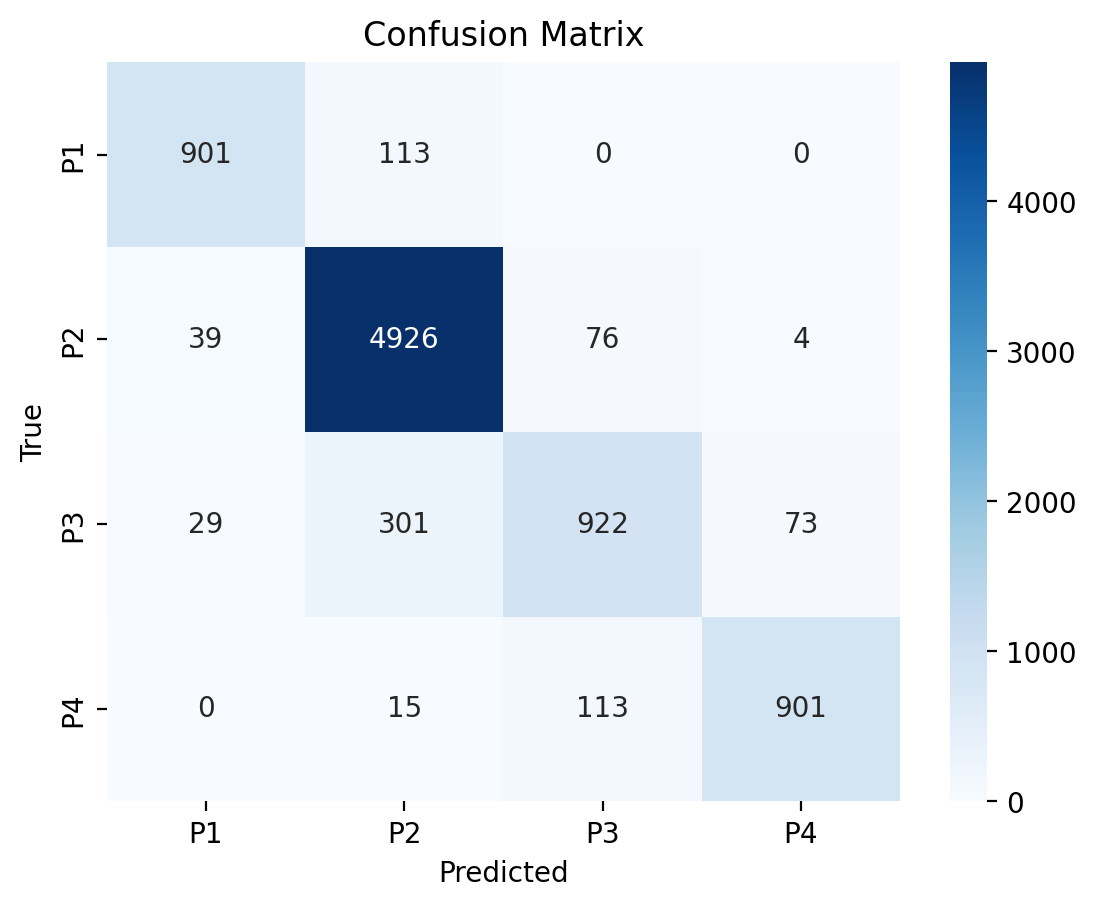

In [64]:
y_pred = svc.predict(X_test_std)  # Predictions of the model
cm = confusion_matrix(y_test, y_pred)  # True labels vs Predicted labels

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['P1', 'P2', 'P3', 'P4'], yticklabels=['P1', 'P2', 'P3', 'P4'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

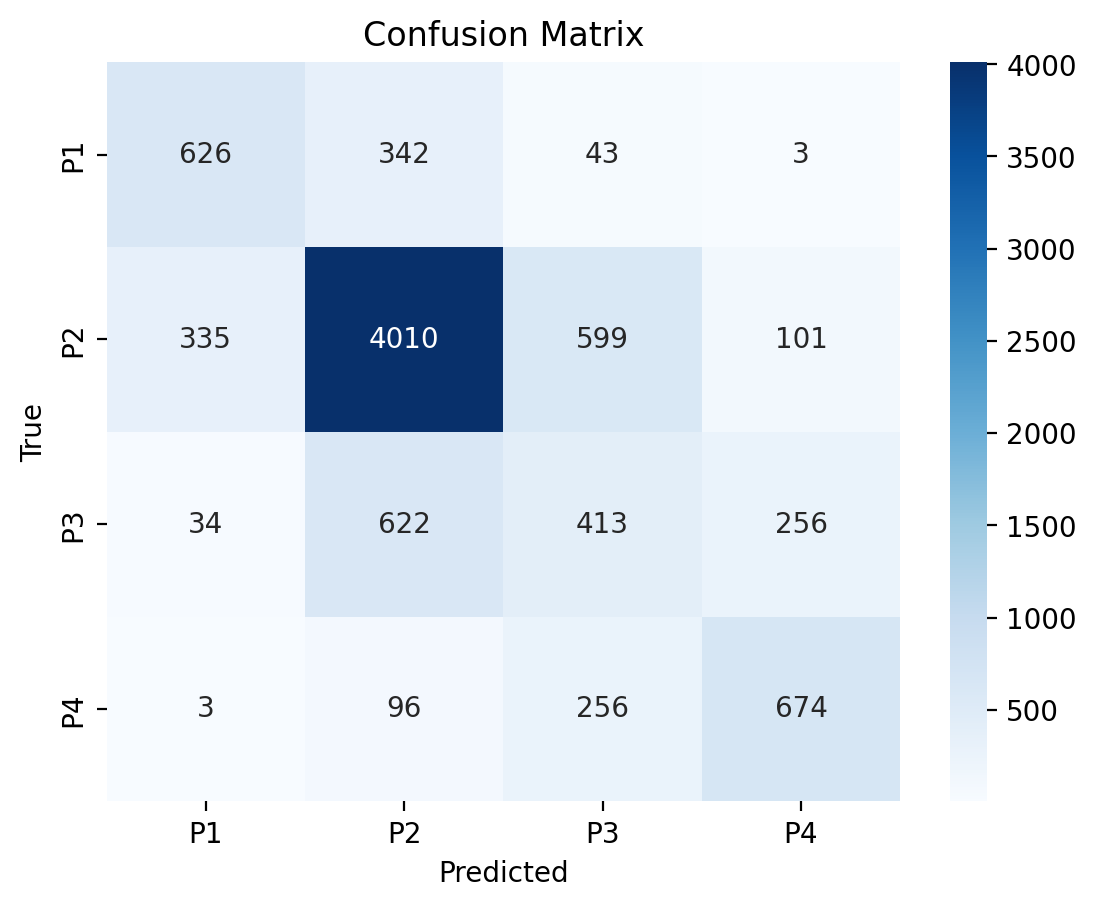

In [45]:
y_pred = dt.predict(X_test)  # Predictions of the model
cm = confusion_matrix(y_test, y_pred)  # True labels vs Predicted labels

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['P1', 'P2', 'P3', 'P4'], yticklabels=['P1', 'P2', 'P3', 'P4'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

actual P3 is getting predicted as P2 and P4. Input data corresponding to P3 also doesn't show any pattern or correspondence with false prediction.

In [65]:
X_test[(pd.Series(y_pred) != 'P3') & (y_test['Approved_Flag'] == 'P3')]

,Total_TL,Tot_Closed_TL,Tot_Active_TL,Total_TL_opened_L6M,Tot_TL_closed_L6M,pct_tl_open_L6M,pct_tl_closed_L6M,pct_active_tl,pct_closed_tl,Total_TL_opened_L12M,Tot_TL_closed_L12M,pct_tl_open_L12M,pct_tl_closed_L12M,Tot_Missed_Pmnt,Auto_TL,CC_TL,Consumer_TL,Gold_TL,Home_TL,PL_TL,Secured_TL,Unsecured_TL,Other_TL,Age_Oldest_TL,Age_Newest_TL,time_since_recent_payment,time_since_first_deliquency,time_since_recent_deliquency,num_times_delinquent,max_delinquency_level,max_recent_level_of_deliq,num_deliq_6mts,num_deliq_12mts,num_deliq_6_12mts,max_deliq_6mts,max_deliq_12mts,num_times_30p_dpd,num_times_60p_dpd,num_std,num_std_6mts,num_std_12mts,num_sub,num_sub_6mts,num_sub_12mts,num_dbt,num_dbt_6mts,num_dbt_12mts,num_lss,num_lss_6mts,num_lss_12mts,recent_level_of_deliq,tot_enq,CC_enq,CC_enq_L6m,CC_enq_L12m,PL_enq,PL_enq_L6m,PL_enq_L12m,time_since_recent_enq,enq_L12m,enq_L6m,enq_L3m,EDUCATION,AGE,NETMONTHLYINCOME,Time_With_Curr_Empr,pct_of_active_TLs_ever,pct_opened_TLs_L6m_of_L12m,pct_currentBal_all_TL,CC_Flag,PL_Flag,pct_PL_enq_L6m_of_L12m,pct_CC_enq_L6m_of_L12m,pct_PL_enq_L6m_of_ever,pct_CC_enq_L6m_of_ever,HL_Flag,GL_Flag,Credit_Score,MARITALSTATUS_Married,MARITALSTATUS_Single,GENDER_F,GENDER_M,last_prod_enq2_AL,last_prod_enq2_CC,last_prod_enq2_ConsumerLoan,last_prod_enq2_HL,last_prod_enq2_PL,last_prod_enq2_others,first_prod_enq2_AL,first_prod_enq2_CC,first_prod_enq2_ConsumerLoan,first_prod_enq2_HL,first_prod_enq2_PL,first_prod_enq2_others
4227,1,1,0,0,0,0.000,0.000,0.000,1.000,0,0,0.000,0.000,0,1,0,0,0,0,0,1,0,0,50.0,50.0,533.0,0.0,0.0,0,0.0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1507.0,0.0,0.0,0.0,3,22,18000,65,0.000,0.000,0.000,0,0,0.0,0.0,0.0,0.0,0,0,702,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,True
4758,5,4,1,0,4,0.000,0.800,0.200,0.800,2,4,0.400,0.800,0,1,0,4,0,0,0,1,4,0,38.0,8.0,62.0,13.0,10.0,4,67.0,5,0,2,2,0.0,8.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,5,5.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,3.0,3.0,3.0,3,41,30000,66,0.200,0.000,0.000,0,0,0.0,0.0,0.0,0.0,0,0,659,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True
7092,1,0,1,0,0,0.000,0.000,1.000,0.000,0,0,0.000,0.000,0,1,0,0,0,0,0,1,0,0,24.0,24.0,215.0,0.0,0.0,0,0.0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,3,27,35000,131,1.000,0.000,0.000,0,0,0.0,0.0,0.0,0.0,0,0,665,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True
751,19,14,5,1,0,0.053,0.000,0.263,0.737,3,3,0.158,0.158,2,1,0,2,4,0,0,15,4,12,53.0,5.0,35.0,25.0,19.0,6,3.0,3,0,0,0,0.0,0.0,0,0,87,9,19,0,0,0,0,0,0,0,0,0,3,9.0,0.0,0.0,0.0,1.0,0.0,0.0,706.0,0.0,0.0,0.0,1,36,12000,130,0.263,0.333,0.454,0,0,0.0,0.0,0.0,0.0,1,0,702,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True
2579,3,2,1,1,2,0.333,0.667,0.333,0.667,1,2,0.333,0.667,0,0,0,2,0,0,0,0,3,1,16.0,5.0,85.0,5.0,4.0,4,28.0,27,4,4,0,28.0,28.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,2.0,0.0,0.0,0.0,1.0,1.0,1.0,143.0,1.0,1.0,0.0,4,23,20000,61,0.333,1.000,0.700,0,0,1.0,0.0,1.0,0.0,0,0,666,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7489,2,2,0,0,0,0.000,0.000,0.000,1.000,0,1,0.000,0.500,0,1,0,0,0,0,0,1,1,1,89.0,82.0,343.0,25.0,19.0,7,900.0,29,0,0,0,0.0,0.0,6,6,17,0,2,2,0,0,0,0,0,0,0,0,29,2.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,1.0,1.0,1.0,1,25,45000,147,0.000,0.000,0.000,0,0,0.0,0.0,0.0,0.0,0,0,659,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,True
5214,68,57,11,1,0,0.015,0.000,0.162,0.838,3,0,0.044,0.00

In [66]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [67]:
best_rf = RandomForestClassifier(max_depth= None, min_samples_leaf= 1, min_samples_split= 10, n_estimators= 200)
best_rf = basic_model(best_rf, X_train, X_test, y_train, y_test)

RandomForestClassifier(min_samples_split=10, n_estimators=200) accuracy: 0.9884702246523238
p1 class:
precision: 0.9315448658649399
recall: 0.9930966469428008
f1score: 0.9613365155131266
p2 class:
precision: 0.9970355731225297
recall: 1.0
f1score: 0.9985155863433943
p3 class:
precision: 0.9943865276663993
recall: 0.9358490566037736
f1score: 0.9642301710730949
p4 class:
precision: 0.9990243902439024
recall: 0.9951409135082604
f1score: 0.997078870496592


In [49]:
xgb = XGBClassifier()
xgb = basic_model(xgb, X_train, X_test, y_train_encoded, y_test_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...) accuracy: 0.7680969927493165
p1 class:
precision: 0.8036951501154734
recall: 0.6863905325443787
f1score: 0.7404255319148936
p2 class:
precision: 0.8158081705150977
recall: 0.910406342913776
f1score: 0.8605152224824355
p3 class:
preci

XGB is performing better than SVC while being computationally less expensive. fine-tuning XGB.

### fine-tuning

In [68]:
param_grid = {
    'n_estimators': [None, 50, 100, 150, 300],          # Number of trees
    'learning_rate': [0.01, 0.1, 0.2],      # Learning rate
    'max_depth': [3, 5, 7],                 # Maximum tree depth
    'subsample': [0.8, 1.0],                # Subsample ratio of the training data
    'colsample_bytree': [0.8, 1.0],         # Subsample ratio of columns
}

grid_search_xgb = GridSearchCV(estimator=XGBClassifier(random_state=42), 
                               param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1_weighted')

grid_search_xgb.fit(X_train, y_train_encoded)

print("Best Parameters:", grid_search_xgb.best_params_)
print("Best Score:", grid_search_xgb.best_score_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Best Score: 0.7578588138900019


In [70]:
importance = grid_search_xgb.best_estimator_.feature_importances_
features = X_train.columns

features[np.argmax(importance)]

'enq_L3m'

In [61]:
features_with_importance = sorted(
    zip(features, importance),
    key=lambda x: x[1],
    reverse=True
)

features_with_importance

[('enq_L3m', 0.20030604),
 ('Age_Oldest_TL', 0.08955781),
 ('time_since_recent_deliquency', 0.07213204),
 ('pct_PL_enq_L6m_of_ever', 0.06308141),
 ('time_since_recent_enq', 0.032297265),
 ('max_deliq_12mts', 0.027259974),
 ('Secured_TL', 0.020953357),
 ('Age_Newest_TL', 0.01967959),
 ('max_delinquency_level', 0.01805858),
 ('pct_currentBal_all_TL', 0.01703543),
 ('HL_Flag', 0.016653322),
 ('Other_TL', 0.01605532),
 ('recent_level_of_deliq', 0.014783797),
 ('first_prod_enq2_PL', 0.014379232),
 ('Home_TL', 0.014359768),
 ('Tot_Missed_Pmnt', 0.014257642),
 ('pct_tl_open_L12M', 0.012395156),
 ('PL_TL', 0.012289203),
 ('time_since_recent_payment', 0.011188581),
 ('num_times_delinquent', 0.011145572),
 ('pct_tl_closed_L12M', 0.0111354785),
 ('first_prod_enq2_ConsumerLoan', 0.010958741),
 ('last_prod_enq2_others', 0.010774135),
 ('last_prod_enq2_CC', 0.01070203),
 ('num_times_60p_dpd', 0.0106605105),
 ('first_prod_enq2_CC', 0.010632253),
 ('CC_TL', 0.010495204),
 ('Total_TL_opened_L6M', 0.010

In [ ]:
# saving the best model
pickle.dump(grid_search_xgb.best_estimator_, open('../artifacts/xgb_best_v1.pkl', 'wb'))

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)

print("Best Parameters:", grid_search_rf.best_params_)
print("Best Score:", grid_search_rf.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [97]:
svc.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [98]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [10, 1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

svc = SVC(random_state=42)
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_std, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


KeyboardInterrupt: 

## P3 vs Rest Modeling

In [60]:
# testing P3 vs rest model

y_train_encoded_p3rest = y_train_encoded.copy()
y_train_encoded_p3rest[y_train_encoded == 2] = 1
y_train_encoded_p3rest[y_train_encoded != 2] = 0

y_test_encoded_p3rest = y_test_encoded.copy()
y_test_encoded_p3rest[y_test_encoded == 2] = 1
y_test_encoded_p3rest[y_test_encoded != 2] = 0

In [61]:
print(np.unique(y_train_encoded_p3rest, return_counts=True), '\n',
      np.unique(y_test_encoded_p3rest, return_counts=True))

(array([0, 1]), array([28536,  5115], dtype=int64)) 
 (array([0, 1]), array([7088, 1325], dtype=int64))


In [62]:
xgb_p3rest = XGBClassifier()
xgb_p3rest.fit(X_train, y_train_encoded_p3rest)
acc = xgb_p3rest.score(X_test, y_test_encoded_p3rest)
print('model accuracy:', acc)

precision, recall, f1, _ = precision_recall_fscore_support(y_test_encoded_p3rest, xgb_p3rest.predict(X_test))
for i, label in enumerate(['!P3', 'P3']):
    print(label, 'class:')
    print('precision:', precision[i])
    print('recall:', recall[i])
    print('f1score:', f1[i]) 

model accuracy: 0.8357304172114585
!P3 class:
precision: 0.8560019965061143
recall: 0.9678329571106095
f1score: 0.908488941862005
P3 class:
precision: 0.42857142857142855
recall: 0.1290566037735849
f1score: 0.19837587006960558


In [63]:
confusion_matrix(y_test_encoded_p3rest, xgb_p3rest.predict(X_test))

array([[6860,  228],
       [1154,  171]], dtype=int64)

In [64]:
confusion_matrix(y_test_encoded, grid_search_xgb.best_estimator_.predict(X_test))

NameError: name 'grid_search_xgb' is not defined

P3 vs rest didn't shows scope for improvement in P3 classificaiton over multi-class modeling.

In [65]:
weights = np.where(y_train_encoded_p3rest == 0, 1, 6)  # Apply weights for 0 and 1
scale_weights = (weights.sum() / weights[weights == 1].sum())

In [66]:
# xgb with custom weights for feature
xgb = XGBClassifier(scale_pos_weight=scale_weights, n_estimators=200, 
                    n_jobs=-1, verbosity=2, random_state=42)
xgb.fit(X_train, y_train_encoded_p3rest)
xgb.score(X_test, y_test_encoded_p3rest)
print('P3 vs Rest model accuracy:', accuracy_score(y_test_encoded_p3rest, xgb.predict(X_test)))
precision, recall, f1, _ = precision_recall_fscore_support(y_test_encoded_p3rest, xgb.predict(X_test))
for i, label in enumerate(['Rest', 'P3']):
    print(label, 'class:')
    print('precision:', precision[i])
    print('recall:', recall[i])
    print('f1score:', f1[i])

P3 vs Rest model accuracy: 0.8164745037442054
Rest class:
precision: 0.8859649122807017
recall: 0.897714446952596
f1score: 0.8918009810791871
P3 class:
precision: 0.4110479285134037
recall: 0.3818867924528302
f1score: 0.39593114241001565


In [53]:
confusion_matrix(y_test_encoded_p3rest, xgb.predict(X_test))

array([[7113,  271],
       [ 254,  775]], dtype=int64)

## Treating Imablanced Data

In [79]:
from imblearn.under_sampling import RandomUnderSampler
under_sampler = RandomUnderSampler(random_state=42)
X_train_bal, y_train_bal = under_sampler.fit_resample(X_train, y_train_encoded)
X_test_bal, y_test_bal = under_sampler.fit_resample(X_test, y_test_encoded)


In [80]:
xgb_bal = basic_model(XGBClassifier(), X_train_bal, X_test_bal, y_train_bal, y_test_bal)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...) accuracy: 0.7206607495069034
p1 class:
precision: 0.8518518518518519
recall: 0.8846153846153846
f1score: 0.8679245283018868
p2 class:
precision: 0.7096774193548387
recall: 0.650887573964497
f1score: 0.6790123456790124
p3 class:
preci

In [81]:
basic_model(SVC(), X_train_bal, X_test_bal, y_train_bal, y_test_bal)

SVC() accuracy: 0.34072978303747536
p1 class:
precision: 0.5047169811320755
recall: 0.42209072978303747
f1score: 0.4597207303974222
p2 class:
precision: 0.3269230769230769
recall: 0.016765285996055226
f1score: 0.03189493433395872
p3 class:
precision: 0.29246935201401053
recall: 0.4940828402366864
f1score: 0.3674367436743675
p4 class:
precision: 0.30214830214830213
recall: 0.42998027613412226
f1score: 0.3549043549043549


SVC()

## P2 vs Rest Modeling

In [39]:
y_train_encoded_p2rest = y_train_encoded.copy()
y_train_encoded_p2rest[y_train_encoded == 1] = 1
y_train_encoded_p2rest[y_train_encoded != 1] = 0

y_test_encoded_p2rest = y_test_encoded.copy()
y_test_encoded_p2rest[y_test_encoded == 1] = 1
y_test_encoded_p2rest[y_test_encoded != 1] = 0

In [41]:
xgb_p2rest = XGBClassifier()
xgb_p2rest.fit(X_train, y_train_encoded_p2rest)
acc = xgb_p2rest.score(X_test, y_test_encoded_p2rest)
acc

0.8226554142398669

In [43]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test_encoded_p2rest, xgb_p2rest.predict(X_test))
for i, label in enumerate(['Rest', 'P2']):
    print(label, 'class:')
    print('precision:', precision[i])
    print('recall:', recall[i])
    print('f1score:', f1[i])

Rest class:
precision: 0.8181818181818182
recall: 0.7161520190023754
f1score: 0.7637745408486384
P2 class:
precision: 0.8250686184812442
recall: 0.8937561942517344
f1score: 0.8580399619410085


In [44]:
confusion_matrix(y_test_encoded_p2rest, xgb_p2rest.predict(X_test))

array([[2412,  956],
       [ 536, 4509]], dtype=int64)

### rest (P1, P3, P4) modeling

In [108]:
train_idx = np.argwhere(y_train_encoded_p2rest == 0).flatten()
test_idx = np.argwhere(y_test_encoded_p2rest == 0).flatten()

In [109]:
xgb_rest = XGBClassifier()
xgb_rest.fit(X_train.iloc[train_idx], 
             label_encoder.fit_transform(y_train_encoded[train_idx]))
xgb_rest.score(X_test.iloc[test_idx], 
               label_encoder.fit_transform(y_test_encoded[test_idx]))

0.8120546318289786

In [110]:
precision, recall, f1, _ = precision_recall_fscore_support(label_encoder.fit_transform(y_test_encoded[test_idx]), 
                                                           xgb_rest.predict(X_test.iloc[test_idx]))
for i, label in enumerate(['P1', 'P3', 'P4']):
    print(label, 'class:')
    print('precision:', precision[i])
    print('recall:', recall[i])
    print('f1score:', f1[i])

P1 class:
precision: 0.9170593779453345
recall: 0.9595660749506904
f1score: 0.9378313253012047
P3 class:
precision: 0.7675134719014627
recall: 0.7524528301886793
f1score: 0.759908536585366
P4 class:
precision: 0.7589285714285714
recall: 0.7434402332361516
f1score: 0.7511045655375552


In [111]:
y_test_encoded_p2rest.shape

(8413,)

In [124]:
# For final prediction, we will

final_pred = np.empty_like(xgb_p2rest.predict(X_test), dtype='object')
final_pred[y_test_encoded_p2rest == 1] = 'P2'
final_pred[y_test_encoded_p2rest == 0] = np.array(['P1', 'P3', 'P4'])[xgb_rest.predict(X_test.iloc[test_idx])]


In [125]:
accuracy_score(y_test, final_pred)

0.9247593010816594

In [127]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, final_pred)
for precision, recall, f1, label in zip(precision, recall, f1, ['P1', 'P2', 'P3', 'P4']):
    print(label, 'class:')
    print('precision:', precision)
    print('recall:', recall)
    print('f1score:', f1)

P1 class:
precision: 0.9170593779453345
recall: 0.9595660749506904
f1score: 0.9378313253012047
P2 class:
precision: 1.0
recall: 1.0
f1score: 1.0
P3 class:
precision: 0.7675134719014627
recall: 0.7524528301886793
f1score: 0.759908536585366
P4 class:
precision: 0.7589285714285714
recall: 0.7434402332361516
f1score: 0.7511045655375552


In [128]:
df['Approved_Flag'].value_counts()

Approved_Flag
P2    25452
P3     6440
P4     5264
P1     4908
Name: count, dtype: int64

# P2 vs Rest worked

P2 vs rest followed by P1 vs P3 vs P4 (rest) performed good enough with p3 class f1_score of 0.76. 

In P2 vs rest, the model is prediciting unnecessary P2 (actually rest). This require improvement. 

# Analyse for poor class performance

In [87]:
from scipy.stats import zscore

z = zscore( df.select_dtypes(include='number').drop(columns='PROSPECTID'), axis=1)
(abs(z) > 3).sum()[(abs(z) > 3).sum() > 0]

Age_Oldest_TL                    8
time_since_recent_payment       60
max_delinquency_level            5
time_since_recent_enq           69
NETMONTHLYINCOME             41909
Time_With_Curr_Empr             73
dtype: int64

In [76]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['NETMONTHLYINCOME', 'PROSPECTID', 'Approved_Flag'], axis=1), df['Approved_Flag'],
                                                    test_size=0.2, random_state=42)

dt1 = basic_model(DecisionTreeClassifier(), X_train, X_test, y_train, y_test)

DecisionTreeClassifier() accuracy: 0.6770474266016878
p1 class:
precision: 0.6120434353405726
recall: 0.611439842209073
f1score: 0.6117414898865319
p2 class:
precision: 0.7874405705229794
recall: 0.7879088206144698
f1score: 0.7876746259784009
p3 class:
precision: 0.3161538461538462
recall: 0.31018867924528304
f1score: 0.3131428571428571
p4 class:
precision: 0.655893536121673
recall: 0.6705539358600583
f1score: 0.6631427198462277


In [82]:
pd.DataFrame(dt1.feature_importances_, index=X_train.columns, columns=['importance']).sort_values(by='importance', ascending=False)

,importance
Age_Oldest_TL,0.188885
enq_L3m,0.138576
time_since_recent_enq,0.091140
time_since_recent_deliquency,0.071042
Time_With_Curr_Empr,0.055822
pct_currentBal_all_TL,0.049053
time_since_recent_payment,0.049024
Age_Newest_TL,0.041069
pct_PL_enq_L6m_of_ever,0.035752
Secured_TL,0.025216
